In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.splits import create_splits_scenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from einops import rearrange, repeat

import os

import sys
# sys.path.append('/mnt/cache/wangxiaodong/SVD-Sense/src')

In [2]:
DATAROOT = '/root/autodl-tmp/nuscenes/mini'

class frameDataset():
    def __init__(self, split='mini_train'):
        self.split = split

        # self.nusc = NuScenes(version='v1.0-trainval', dataroot=DATAROOT, verbose=True)
        self.nusc = NuScenes(version='v1.0-mini', dataroot=DATAROOT, verbose=True)

        self.splits = create_splits_scenes()
        print(self.splits)

        # training samples
        self.samples = self.get_samples(split)
        print('Total samples: %d' % len(self.samples))
        self.samples_groups = self.group_sample_by_scene(split)
    def __len__(self):
        return len(self.samples)
    
    def get_samples(self, split='mini_train'):
        scenes = self.splits[split]
        samples = [samp for samp in self.nusc.sample if
                   self.nusc.get('scene', samp['scene_token'])['name'] in scenes]
        return samples
    def group_sample_by_scene(self, split='mini_train'):
        scenes = self.splits[split]
        samples_dict = {}
        for sce in scenes:
            samples_dict[sce] = [] # empty list
        for samp in self.nusc.sample:
            scene_token = samp['scene_token']
            scene = self.nusc.get('scene', scene_token)
            tmp_sce = scene['name']
            if tmp_sce in scenes:
                samples_dict[tmp_sce].append(samp)
        return samples_dict

    def get_image_path_from_sample(self, my_sample):
        sample_data = self.nusc.get('sample_data', my_sample['data']['CAM_FRONT'])
        file_path = sample_data['filename']
        utime = file_path.split('__')[-1].split('.')[0]

        image_path = os.path.join(DATAROOT, file_path)
        
        return image_path

In [3]:
dataset = frameDataset()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.388 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
{'train': ['scene-0001', 'scene-0002', 'scene-0004', 'scene-0005', 'scene-0006', 'scene-0007', 'scene-0008', 'scene-0009', 'scene-0010', 'scene-0011', 'scene-0019', 'scene-0020', 'scene-0021', 'scene-0022', 'scene-0023', 'scene-0024', 'scene-0025', 'scene-0026', 'scene-0027', 'scene-0028', 'scene-0029', 'scene-0030', 'scene-0031', 'scene-0032', 'scene-0033', 'scene-0034', 'scene-0041', 'scene-0042', 'scene-0043', 'scene-0044', 'scene-0045', 'scene-0046', 'scene-0047', 'scene-0048', 'scene-0049', 'scene-0050', 'scene-0051', 'scene-0052', 'scene-0053', 'scene-0054', 'scene-0055', 'scene-0056', 'scene-0057', 'scene-0058', 'scene-0059', 'scene-0060', 'scene-0061', 'scene-0

In [4]:
scenes_list = list(dataset.samples_groups.keys())
scenes_list[0]

'scene-0061'

In [5]:
dataset.splits["mini_train"]

['scene-0061',
 'scene-0553',
 'scene-0655',
 'scene-0757',
 'scene-0796',
 'scene-1077',
 'scene-1094',
 'scene-1100']

In [6]:
dataset.splits["mini_val"]

['scene-0103', 'scene-0916']

In [7]:
len(dataset.samples_groups["scene-0061"])

39

In [12]:
# get image path from given samples
samples = dataset.samples_groups["scene-0061"]

sample_paths = [dataset.get_image_path_from_sample(sam) for sam in samples]

len(sample_paths)

39

In [16]:
import os
os.system("mkdir -p scene-0061")
for path in sample_paths:
    path = path.replace('mini', 'all')
    os.system(f"cp {path} scene-0061")

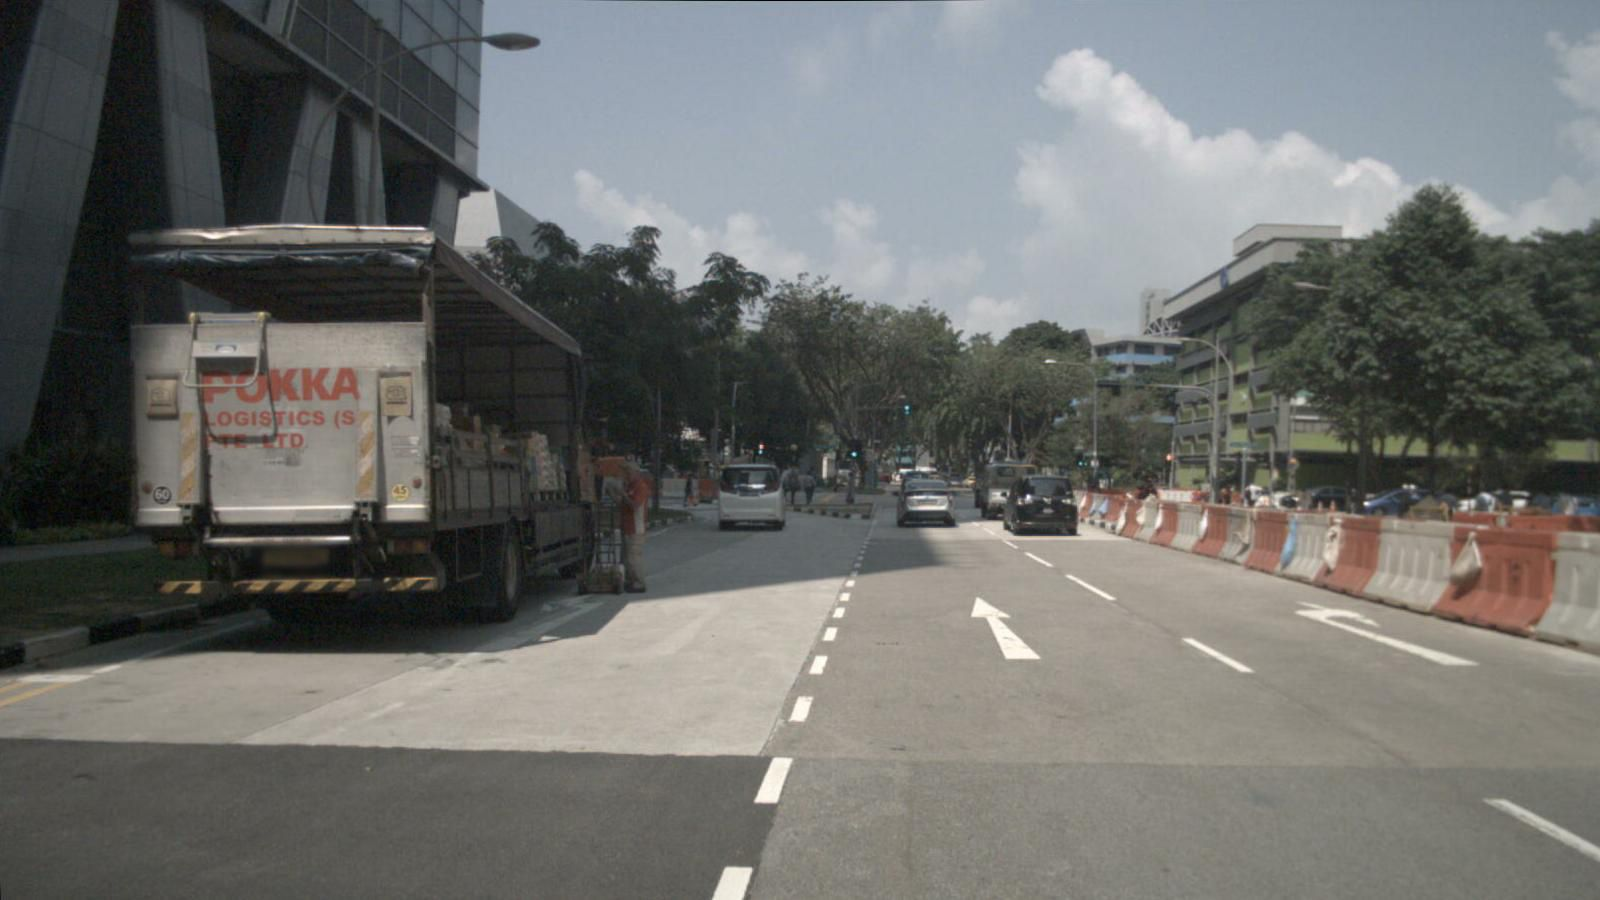

In [10]:
from PIL import Image

pil = Image.open("/root/autodl-tmp/nuscenes/all/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg")

pil

In [3]:
nusc_can = NuScenesCanBus(dataroot=DATAROOT)

In [6]:
# parse each scene, and match the actions
# sample in each scene, are ordered
# first align frames with actions
###NOTE: we judge the frame and action alignment
match_first = []
match_second = []
for sce in tqdm(scenes_list):
    try:
        veh_speed = nusc_can.get_messages(sce, 'vehicle_monitor')
        first_speed_item = veh_speed[0]
        speed_item_num = len(veh_speed)
        first_speed_time = first_speed_item['utime']
        frame_samples = dataset.samples_groups[sce]
        samples_num = len(frame_samples)
        # first sample
        sample_1_token = frame_samples[0]['data']['CAM_FRONT']
        sample_1_path = dataset.nusc.get('sample_data', sample_1_token)['filename']
        sample_1_utime = int(sample_1_path.split('__')[-1].split('.')[0])
        # second sample
        sample_2_token = frame_samples[1]['data']['CAM_FRONT']
        sample_2_path = dataset.nusc.get('sample_data', sample_2_token)['filename']
        sample_2_utime = int(sample_2_path.split('__')[-1].split('.')[0])
        # 计算差距
        dis_1 = first_speed_time - sample_1_utime
        dis_2 = first_speed_time - sample_2_utime
        # print(sce, dis_1, dis_2)
        
        if(abs(dis_1)<=abs(dis_2)):
            if(abs(dis_1)<500000):
              match_first.append(sce)
        else:
            if(abs(dis_2)<500000):
              match_second.append(sce)
    except Exception as e:
        print(f'error in {sce}')

 17%|█▋        | 117/700 [00:01<00:06, 88.44it/s] 

error in scene-0161
error in scene-0162
error in scene-0163
error in scene-0164
error in scene-0165
error in scene-0166
error in scene-0167
error in scene-0168
error in scene-0170
error in scene-0171
error in scene-0172
error in scene-0173
error in scene-0174
error in scene-0175
error in scene-0176


 40%|████      | 283/700 [00:03<00:05, 78.40it/s]/mnt/cachenew2/wangxiaodong/miniconda3/envs/diff/lib/python3.10/site-packages/nuscenes/can_bus/can_bus_api.py:236: UserWarning: Warning: %s does not have any vehicle_monitor messages!
  warnings.warn('Warning: %s does not have any vehicle_monitor messages!')
 42%|████▏     | 291/700 [00:03<00:05, 74.35it/s]

error in scene-0419


100%|██████████| 700/700 [00:08<00:00, 78.01it/s]


In [7]:
len(match_first)

318

In [8]:
len(match_second)

366

In [9]:
frame_action = {}
# 对于match的部分，先直接根据action来选frame
for sce in tqdm(match_first):
    # 第一帧和第一个action时间匹配
    # path, action的值
    frame_action[sce] = []
    
    veh_speed = nusc_can.get_messages(sce, 'vehicle_monitor')
    speed_item_num = len(veh_speed) # gold
    # steering, vehicle_speed
    frame_samples = dataset.samples_groups[sce]
    samples_num = len(frame_samples)
    # first sample
    minilen = min(speed_item_num, samples_num)
    tmp_steer = []
    tmp_speed = []
    tmp_path = []
    for i in range(minilen):
        speed_item = veh_speed[i]
        steer = speed_item['steering']
        speed = speed_item['vehicle_speed']
        
        sample_token = frame_samples[i]['data']['CAM_FRONT']
        sample_path = dataset.nusc.get('sample_data', sample_token)['filename']

        tmp_steer.append(steer)
        tmp_speed.append(speed)
        tmp_path.append(sample_path)
    frame_action[sce] = [
        tmp_steer,
        tmp_speed,
        tmp_path
    ]

100%|██████████| 318/318 [00:00<00:00, 914.65it/s]


In [10]:
for sce in tqdm(match_second):
    # 第一帧和第一个action时间匹配
    # path, action的值
    frame_action[sce] = []
    
    veh_speed = nusc_can.get_messages(sce, 'vehicle_monitor')
    speed_item_num = len(veh_speed) # gold
    # steering, vehicle_speed
    frame_samples = dataset.samples_groups[sce][1:] # skip first frame
    samples_num = len(frame_samples)
    # first sample
    minilen = min(speed_item_num, samples_num)
    tmp_steer = []
    tmp_speed = []
    tmp_path = []
    for i in range(minilen):
        speed_item = veh_speed[i]
        steer = speed_item['steering']
        speed = speed_item['vehicle_speed']
        
        sample_token = frame_samples[i]['data']['CAM_FRONT']
        sample_path = dataset.nusc.get('sample_data', sample_token)['filename']

        tmp_steer.append(steer)
        tmp_speed.append(speed)
        tmp_path.append(sample_path)
    frame_action[sce] = [
        tmp_steer,
        tmp_speed,
        tmp_path
    ]

100%|██████████| 366/366 [00:00<00:00, 928.72it/s]


In [11]:
frame_action

{'scene-0048': [[9.800000000000182,
   9.800000000000182,
   8.400000000000091,
   6.400000000000091,
   7.199999999999818,
   9.400000000000091,
   8.400000000000091,
   4.199999999999818,
   6.0,
   5.300000000000182,
   8.400000000000091,
   9.199999999999818,
   6.800000000000182,
   0.6999999999998181,
   -10.900000000000091,
   -34.40000000000009,
   -59.5,
   -60.5,
   -76.30000000000018,
   -86.30000000000018,
   -88.80000000000018,
   -80.59999999999991,
   -76.5,
   -78.09999999999991,
   -83.09999999999991,
   -58.90000000000009,
   -17.300000000000182,
   -4.5,
   -0.5,
   -0.40000000000009095,
   -1.5,
   -6.900000000000091,
   -6.900000000000091,
   -6.300000000000182,
   -4.900000000000091,
   -3.400000000000091,
   -3.5,
   -3.0,
   -4.400000000000091,
   -5.0],
  [39.01,
   37.43,
   35.6,
   33.68,
   31.7,
   30.04,
   28.89,
   28.71,
   29.37,
   29.84,
   29.14,
   28.28,
   26.89,
   25.41,
   23.82,
   22.27,
   21.150000000000002,
   21.61,
   22.77,
   23.75,


In [12]:
steer = torch.tensor(frame_action['scene-0048'][0])
steer.shape

torch.Size([40])

In [13]:
import json
with open('/mnt/lustrenew/wangxiaodong/data/nuscene/frame_action_train.json', 'w') as f:
    json.dump(frame_action, f)

In [4]:
# For validation
dataset = frameDataset('val')

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 41.405 seconds.
Reverse indexing ...
Done reverse indexing in 9.9 seconds.
Total samples: 6019


In [5]:
scenes_list = list(dataset.samples_groups.keys())
len(scenes_list)

150

In [6]:
# parse each scene, and match the actions
# sample in each scene, are ordered
# first align frames with actions
###NOTE: we judge the frame and action alignment
match_first = []
match_second = []
for sce in tqdm(scenes_list):
    try:
        veh_speed = nusc_can.get_messages(sce, 'vehicle_monitor')
        first_speed_item = veh_speed[0]
        speed_item_num = len(veh_speed)
        first_speed_time = first_speed_item['utime']
        frame_samples = dataset.samples_groups[sce]
        samples_num = len(frame_samples)
        # first sample
        sample_1_token = frame_samples[0]['data']['CAM_FRONT']
        sample_1_path = dataset.nusc.get('sample_data', sample_1_token)['filename']
        sample_1_utime = int(sample_1_path.split('__')[-1].split('.')[0])
        # second sample
        sample_2_token = frame_samples[1]['data']['CAM_FRONT']
        sample_2_path = dataset.nusc.get('sample_data', sample_2_token)['filename']
        sample_2_utime = int(sample_2_path.split('__')[-1].split('.')[0])
        # 计算差距
        dis_1 = first_speed_time - sample_1_utime
        dis_2 = first_speed_time - sample_2_utime
        # print(sce, dis_1, dis_2)
        
        if(abs(dis_1)<=abs(dis_2)):
            if(abs(dis_1)<500000):
              match_first.append(sce)
        else:
            if(abs(dis_2)<500000):
              match_second.append(sce)
    except Exception as e:
        print(f'error in {sce}')

100%|██████████| 150/150 [00:03<00:00, 44.71it/s]


In [7]:
len(match_first)

45

In [8]:
len(match_second)

105

In [9]:
frame_action_test = {}
# 对于match的部分，先直接根据action来选frame
for sce in tqdm(match_first):
    # 第一帧和第一个action时间匹配
    # path, action的值
    frame_action_test[sce] = []
    
    veh_speed = nusc_can.get_messages(sce, 'vehicle_monitor')
    speed_item_num = len(veh_speed) # gold
    # steering, vehicle_speed
    frame_samples = dataset.samples_groups[sce]
    samples_num = len(frame_samples)
    # first sample
    minilen = min(speed_item_num, samples_num)
    tmp_steer = []
    tmp_speed = []
    tmp_path = []
    for i in range(minilen):
        speed_item = veh_speed[i]
        steer = speed_item['steering']
        speed = speed_item['vehicle_speed']
        
        sample_token = frame_samples[i]['data']['CAM_FRONT']
        sample_path = dataset.nusc.get('sample_data', sample_token)['filename']

        tmp_steer.append(steer)
        tmp_speed.append(speed)
        tmp_path.append(sample_path)
    frame_action_test[sce] = [
        tmp_steer,
        tmp_speed,
        tmp_path
    ]

100%|██████████| 45/45 [00:00<00:00, 1393.56it/s]


In [10]:
for sce in tqdm(match_second):
    # 第一帧和第一个action时间匹配
    # path, action的值
    frame_action_test[sce] = []
    
    veh_speed = nusc_can.get_messages(sce, 'vehicle_monitor')
    speed_item_num = len(veh_speed) # gold
    # steering, vehicle_speed
    frame_samples = dataset.samples_groups[sce][1:] # skip first frame
    samples_num = len(frame_samples)
    # first sample
    minilen = min(speed_item_num, samples_num)
    tmp_steer = []
    tmp_speed = []
    tmp_path = []
    for i in range(minilen):
        speed_item = veh_speed[i]
        steer = speed_item['steering']
        speed = speed_item['vehicle_speed']
        
        sample_token = frame_samples[i]['data']['CAM_FRONT']
        sample_path = dataset.nusc.get('sample_data', sample_token)['filename']

        tmp_steer.append(steer)
        tmp_speed.append(speed)
        tmp_path.append(sample_path)
    frame_action_test[sce] = [
        tmp_steer,
        tmp_speed,
        tmp_path
    ]

100%|██████████| 105/105 [00:00<00:00, 998.55it/s] 


In [11]:
import json
with open('/mnt/lustrenew/wangxiaodong/data/nuscene/frame_action_val.json', 'w') as f:
    json.dump(frame_action_test, f)

In [12]:
frame_action_test

{'scene-0017': [[-0.40000000000009095,
   -0.900000000000091,
   -3.800000000000182,
   -3.400000000000091,
   1.2999999999997272,
   2.799999999999727,
   0.0,
   -0.8000000000001819,
   3.900000000000091,
   10.599999999999909,
   27.699999999999818,
   27.90000000000009,
   19.699999999999818,
   8.900000000000091,
   -10.200000000000273,
   -18.09999999999991,
   -22.700000000000273,
   -21.800000000000182,
   -15.700000000000273,
   -10.800000000000182,
   -6.300000000000182,
   -0.8000000000001819,
   2.099999999999909,
   4.699999999999818,
   5.199999999999818,
   8.799999999999727,
   13.299999999999727,
   23.699999999999818,
   36.29999999999973,
   47.0,
   64.29999999999973,
   89.19999999999982,
   99.40000000000009,
   99.90000000000009,
   99.0,
   97.69999999999982,
   96.29999999999973,
   96.29999999999973,
   96.29999999999973,
   96.29999999999973],
  [36.87,
   36.02,
   35.14,
   34.29,
   33.3,
   31.89,
   30.240000000000002,
   28.560000000000002,
   27.060000

In [71]:
# for validation

# 采样时，action和frame对应，但是frame没有和caption对应，需要用一个token标记caption，直接获取caption
with open('/ssd_datasets/wxiaodong/nuscene/nuscene_caption_val.json', 'r') as f:
    caption_val = json.load(f)

In [72]:
token_caption = {}
for item in caption_val:
    path = item['path']
    caption = item['caption']
    utime = path.split('__')[-1].split('.')[0]
    token_caption[utime] = caption

In [76]:
with open('/ssd_datasets/wxiaodong/nuscene/nuscene_caption_utime_val.json', 'w') as f:
    json.dump(token_caption, f)

In [16]:
# for training
# for validation

# 采样时，action和frame对应，但是frame没有和caption对应，需要用一个token标记caption，直接获取caption
with open('/mnt/lustrenew/wangxiaodong/data/nuscene/nuscene_caption_train.json', 'r') as f:
    caption_train = json.load(f)

In [17]:
token_caption = {}
for item in caption_train:
    path = item['path']
    caption = item['caption']
    utime = path.split('__')[-1].split('.')[0]
    token_caption[utime] = caption

In [18]:
with open('/mnt/lustrenew/wangxiaodong/data/nuscene/nuscene_caption_utime_train.json', 'w') as f:
    json.dump(token_caption, f)